### A set of scripts to simulate landscape evolution of a scarp over a desired timescale using non-linear diffusion

Non-linear implementation based on Abel Hafiz's MSc code

### User defined options

In [66]:
DEM_name = "DEMs/R1.asc"  # set name of your DEM here
total_time = 10  # set total time of simulation in years here, code will output diffused scarp over that timescale
file_name_export = "test.asc"  # set name of output synthetic DEM here

### Import Python packages and Landlab tools

Landlab docs: https://landlab.readthedocs.io/en/latest/reference/components/taylor_nonlinear_hillslope_flux.html

In [67]:
from landlab.components import TaylorNonLinearDiffuser
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
import numpy as np
from landlab.plot.imshow import imshow_grid
import matplotlib.pyplot as plt
import decimal

### load DEM 

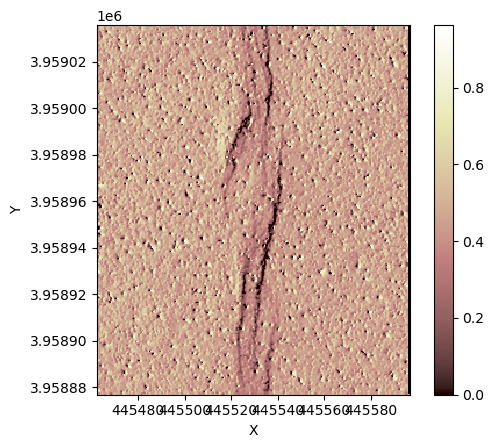

In [68]:
# load DEM -- uses some landlab commands
mg_nonlinear, z_nonlinear = read_esri_ascii(DEM_name, name="topographic__elevation")
np.all(mg_nonlinear.at_node["topographic__elevation"] == z_nonlinear)
mg_nonlinear.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg_nonlinear.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg_nonlinear.calc_hillshade_at_node(elevs=z_nonlinear, alt=30.0, az=100.0)
imshow_grid(mg_nonlinear, hillshade)

### Define 2D diffusion set-up

We define our transport rate and 2D diffusion set-up (using the non-linear diffusion implementation from landlab)

In [69]:
mg_nonlinear.set_closed_boundaries_at_grid_edges(True, True, True, True)
D = 0.001  # m^2/yr
dt = 1
cubicflux = TaylorNonLinearDiffuser(
    mg_nonlinear, linear_diffusivity=D, if_unstable="warn", dynamic_dt=True, nterms=2
)  # nterms from Ganti et al. (2012)

### Simulate diffusion

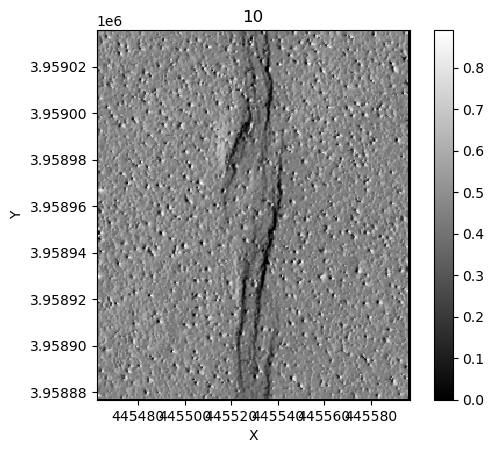

In [70]:
cubicflux.run_one_step(
    total_time
)  # transport limited diffusion, run complete simulation

hillshade = mg_nonlinear.calc_hillshade_at_node(elevs=z_nonlinear, alt=30.0, az=100.0)
imshow_grid(mg_nonlinear, hillshade, cmap="gray")
plt.title(total_time)
z_nonlinear = z_nonlinear[mg_nonlinear.nodes]

### Export synthetic DEM after diffusion

as an ascii file

In [71]:
#write_esri_ascii(file_name_export, mg_nonlinear)

### Compare linear and nonlinear diffusion

In [72]:
# run linear diffusion
mg_linear, z_linear = read_esri_ascii(DEM_name, name="topographic__elevation")
np.all(mg_linear.at_node["topographic__elevation"] == z_linear)
mg_linear.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg_linear.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg_linear.calc_hillshade_at_node(elevs=z_linear, alt=30.0, az=100.0)
slope_t0 = mg_linear.calc_slope_at_node(z_linear)
z_t0 = z_linear[mg_linear.nodes]

D = 0.001  # m2/yr transport coefficient (0.001 m2/yr for Basin and Range)
dt = 0.2 * mg_linear.dx * mg_linear.dx / D  # set time step to 50 yrs
mg_linear.set_closed_boundaries_at_grid_edges(True, True, True, True)
qs = mg_linear.add_zeros("sediment_flux", at="link")

n_iter = int(total_time / dt)

for p in range(n_iter):
    g = mg_linear.calc_grad_at_link(z_linear)
    qs[mg_linear.active_links] = -D * g[mg_linear.active_links]
    dzdt = -mg_linear.calc_flux_div_at_node(qs)
    z_linear[mg_linear.core_nodes] += dzdt[mg_linear.core_nodes] * dt

z_linear = z_linear[mg_linear.nodes]

Text(0.5, 1.0, 'Time = 10 years')

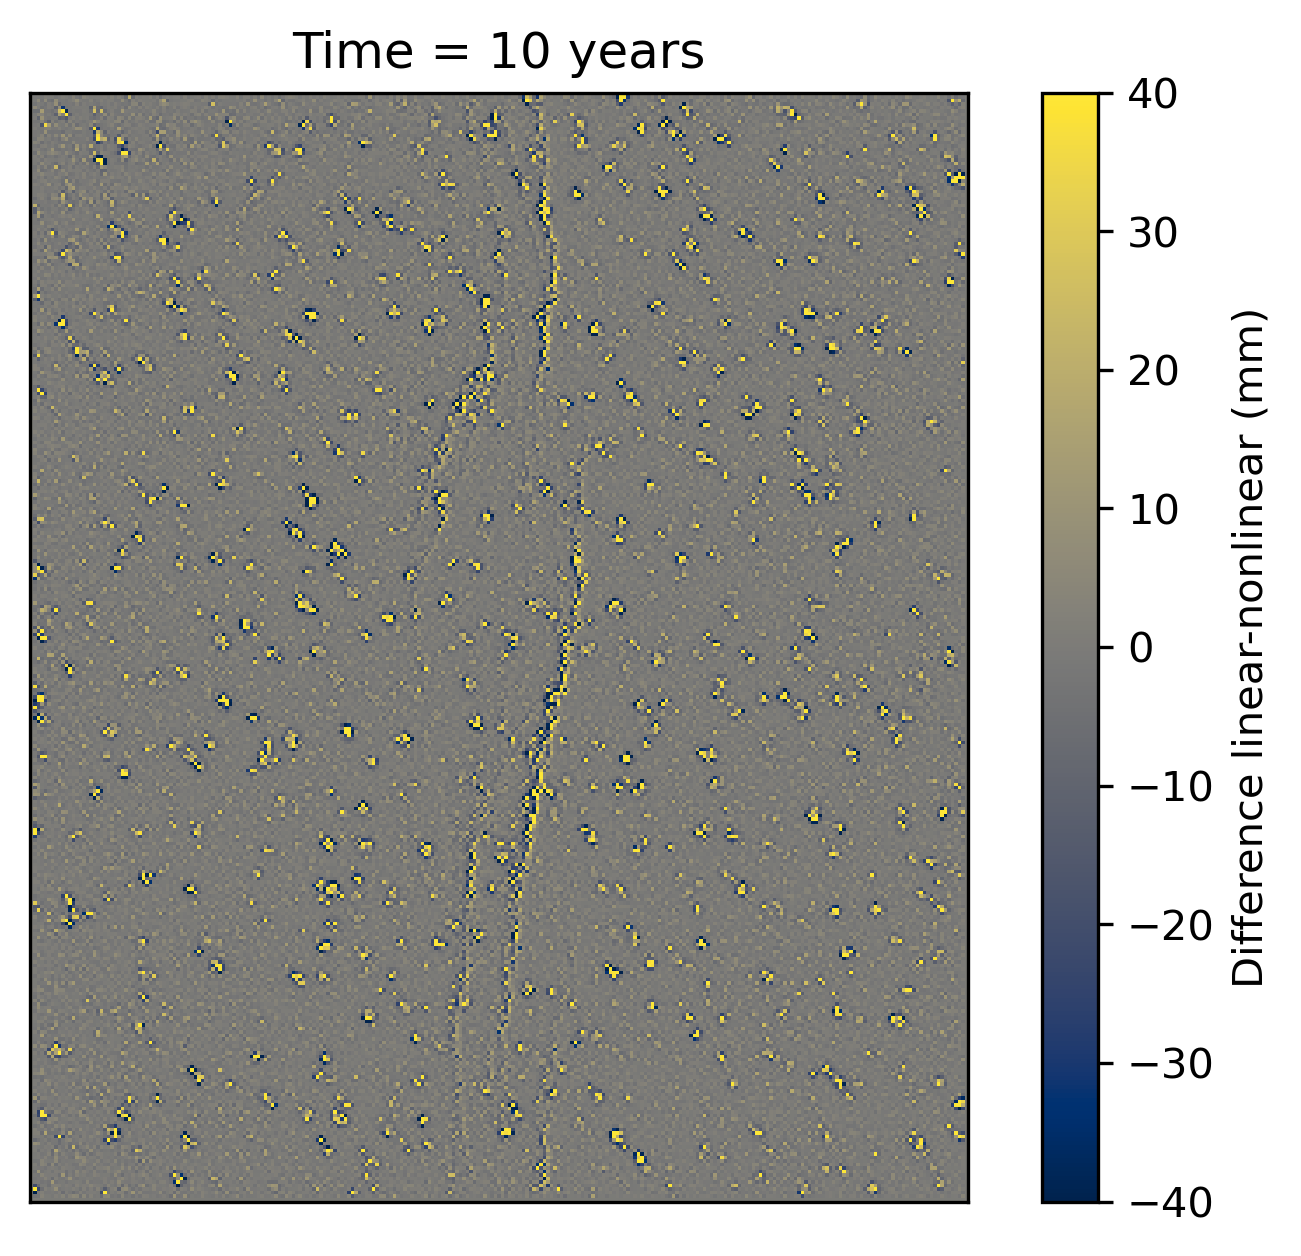

In [73]:
zdiff = z_linear - z_nonlinear
zchange = mg_nonlinear.node_vector_to_raster(zdiff, flip_vertically=True)
plt.figure(dpi=300)
plt.imshow(zchange * 1000, cmap="cividis", vmin=-40, vmax=40)
colorbar = plt.colorbar()
colorbar.set_label("Difference linear-nonlinear (mm)")
plt.yticks([])
plt.xticks([])
plt.title(f"Time = {total_time} years")